In [32]:
#Constructing DNN Model for MIST dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as pt
from sklearn.decomposition import PCA

class DNN_1(nn.Module):
    def __init__(self):
        super(DNN_1, self).__init__()
        self.fc1 = nn.Linear(28*28*1, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
dnn_model = DNN_1()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [39]:
def train_and_calculate_weights(train_loader, train_times):
    weights_for_fc1, weights_for_full_model, full_losses = [], [], []
    i = 0
    
    #Traning the model 8 times
    while i < 8:
        print(f'Training Iteration - ', i)
        model = DNN_1()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = torch.nn.CrossEntropyLoss()
        losses = []
        for number in range(train_times):
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                predicted_outputs = model(inputs)
                loss = criterion(predicted_outputs, labels)
                loss.backward()
                optimizer.step()
                
            #Collecting weights every 3 epochs
            if number%3 == 0:
                weights_for_fc1.append(model.fc1.weight.data.numpy().flatten())
                full_model_weight = np.concatenate([p.data.numpy().flatten() for p in model.parameters()])
                weights_for_full_model.append(full_model_weight)
                losses.append(loss.item())
        full_losses.append(losses)
        i += 1
    return weights_for_fc1, weights_for_full_model, full_losses

In [40]:
def pca_components(fully_connectedlayer_weight, full_dnn_model_weight):
    flatten_fc1_weights = np.vstack(fully_connectedlayer_weight)
    flatten_fm_weights = np.vstack(full_dnn_model_weight)
    
    fc1_model_pca = PCA(n_components=2)
    weights_fc1_pca = fc1_model_pca.fit_transform(flatten_fc1_weights)
    
    fm_model_pca = PCA(n_components=2)
    weights_fm_pca = fm_model_pca.fit_transform(flatten_fm_weights)
    
    return weights_fc1_pca, weights_fm_pca

In [41]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])
training_set = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = trans)
testing_set = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = trans)

train_loader = torch.utils.data.DataLoader(training_set, batch_size=128)
test_loader = torch.utils.data.DataLoader(testing_set, batch_size=64)

fc1_weight,full_weight,full_loss = train_and_calculate_weights(train_loader, 24)

Training Iteration -  0
Training Iteration -  1
Training Iteration -  2
Training Iteration -  3
Training Iteration -  4
Training Iteration -  5
Training Iteration -  6
Training Iteration -  7


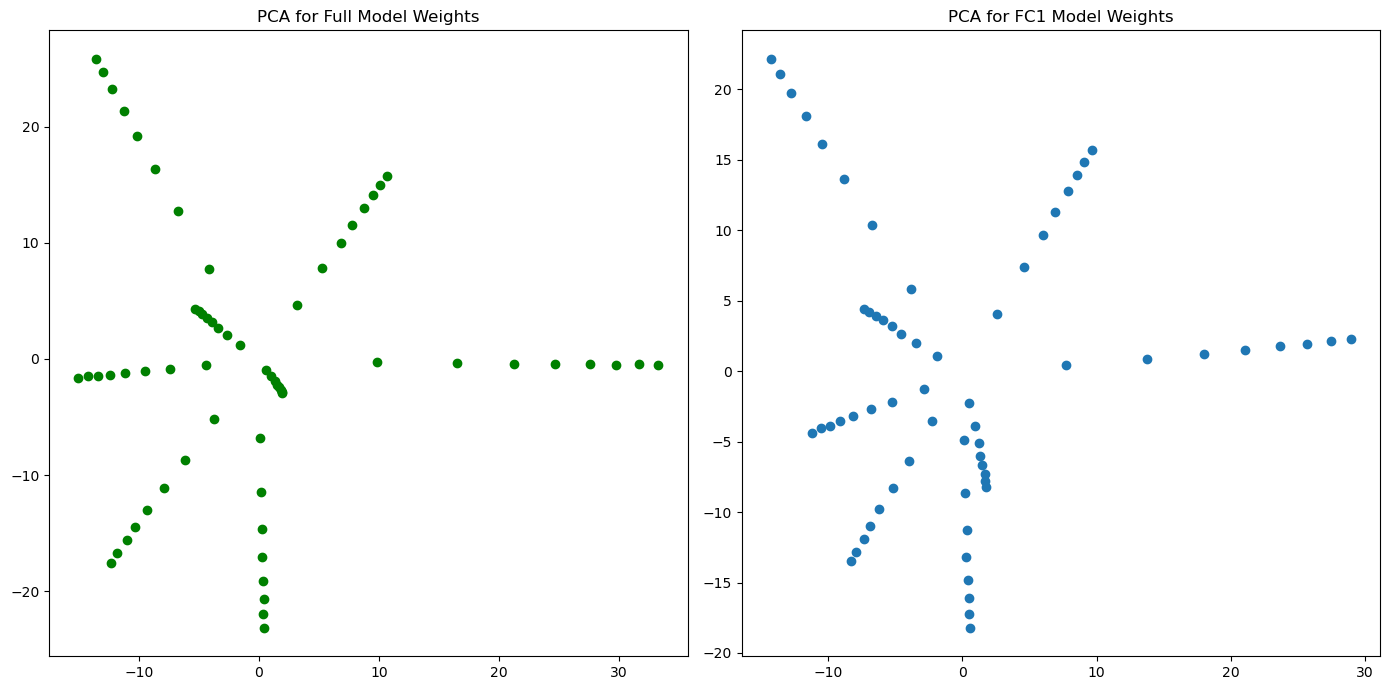

In [49]:
weights_firstlayer_pca, weights_fullmodel_pca = pca_components(fc1_weight, full_weight)
pt.figure(figsize=(14,7))
pt.subplot(1, 2, 1)
pt.scatter(weights_fullmodel_pca[:, 0], weights_fullmodel_pca[:, 1], color="green")
pt.title('PCA for Full Model Weights')

pt.subplot(1, 2, 2)
pt.scatter(weights_firstlayer_pca[:, 0], weights_firstlayer_pca[:, 1])
pt.title('PCA for FC1 Model Weights')

pt.tight_layout()
pt.show()